In [1]:
import numpy as np

In [2]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def col_center(d):
    mean = np.mean(d, axis = 0)
    return d - mean

def col_scale(d):
    norm = np.linalg.norm(d, axis = 0)
    return d/norm

def correlation_matrix(d):
    scaled = col_scale(col_center(d))
    return np.dot(scaled.T,scaled)

In [4]:
%cd ../data

/home/explorer/BMS270/data


In [5]:
!ls *.txt

GSE88801_kallisto_est_counts_thresh10.txt
GSE88801_kallisto_est_counts_thresh1.txt
Mus_musculus.GRCm38.79.ENSEMBL_names.txt


In [6]:
!head Mus_musculus.GRCm38.79.ENSEMBL_names.txt

In [ ]:
!wget 'http://histo.ucsf.edu/BMS270/BMS270_2019/data/Mus_musculus.GRCm38.79.ENSEMBL_names.txt'

In [7]:
from csv import reader, excel_tab

In [9]:
gene2name = {}
fp = reader(open('Mus_musculus.GRCm38.79.ENSEMBL_names.txt'),dialect=excel_tab)
header = next(fp)
for row in fp:
    gene2name[row[0]] = row[1]

In [10]:
len(gene2name)

43629

In [11]:
list(gene2name.items())[:10]

[('ENSMUSG00000090897', 'Esp6Esp5'),
 ('ENSMUSG00000081711', 'Gm11785'),
 ('ENSMUSG00000021709', 'Erbb2ip'),
 ('ENSMUSG00000031224', 'Magee2'),
 ('ENSMUSG00000087203', 'Gm13986'),
 ('ENSMUSG00000097737', 'Gm26530'),
 ('ENSMUSG00000005148', 'Klf5'),
 ('ENSMUSG00000029439', 'Sfswap'),
 ('ENSMUSG00000077202', 'Gm25612'),
 ('ENSMUSG00000026797', 'Stxbp1')]

In [12]:
from csv import reader, excel_tab
orfs = []
names = []
data = []
fin = reader(open("GSE88801_kallisto_TPMs_thresh10.cdt"),dialect=excel_tab)
header = next(fin)[2:]
for row in fin:
    orfs.append(row[0])
    names.append(gene2name[row[0]])
    data.append([float(i) for i in row[2:]])

In [14]:
names[:10]

['Zranb2',
 'Lphn2',
 'Rpf1',
 'Ctbs',
 'Sap30bp',
 'Recql5',
 'Ahnak',
 'Nlrp1a',
 'Atp6v0d2',
 'Cdk10']

In [15]:
D = np.array(data)
D.shape

(9939, 36)

In [16]:
A = col_center(D)

In [17]:
A.shape

(9939, 36)

In [18]:
u,s,v = np.linalg.svd(A.T, full_matrices = False)
u.shape

(36, 36)

<IPython.core.display.Javascript object>


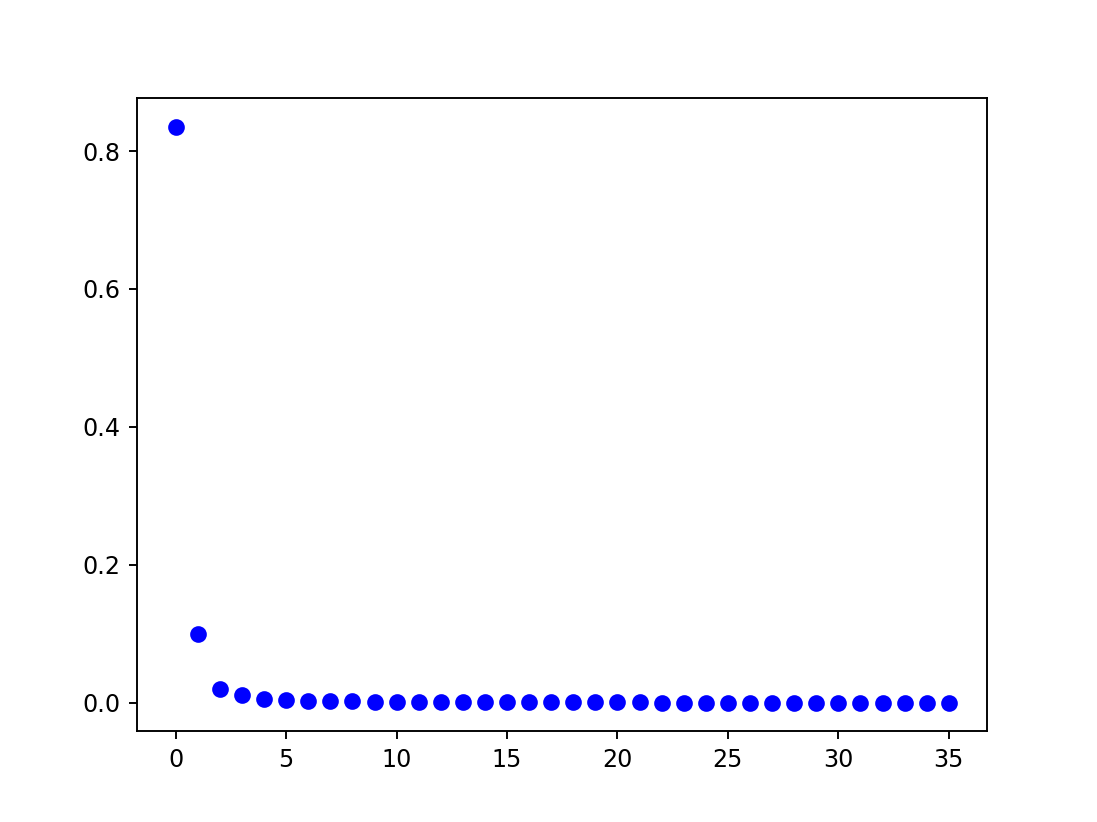

In [19]:
v = s**2
fig = plt.figure()
plt.plot(v/sum(v),"bo")

In [20]:
# Simple blue->yellow non-overlapping gradient
cdict = {"red":((0.,0.,0.),(.5,0.,0.),(1.,1.,1.)),
         "green":((0.,0.,0.),(.5,0.,0.),(1.,1.,1.)),
         "blue":((0.,1.,1.),(.5,0.,0.),(1.,0.,0.))}
# map gradient to 256 actual RGBA values
cmap_yb = LinearSegmentedColormap("yb",cdict,256)

<IPython.core.display.Javascript object>


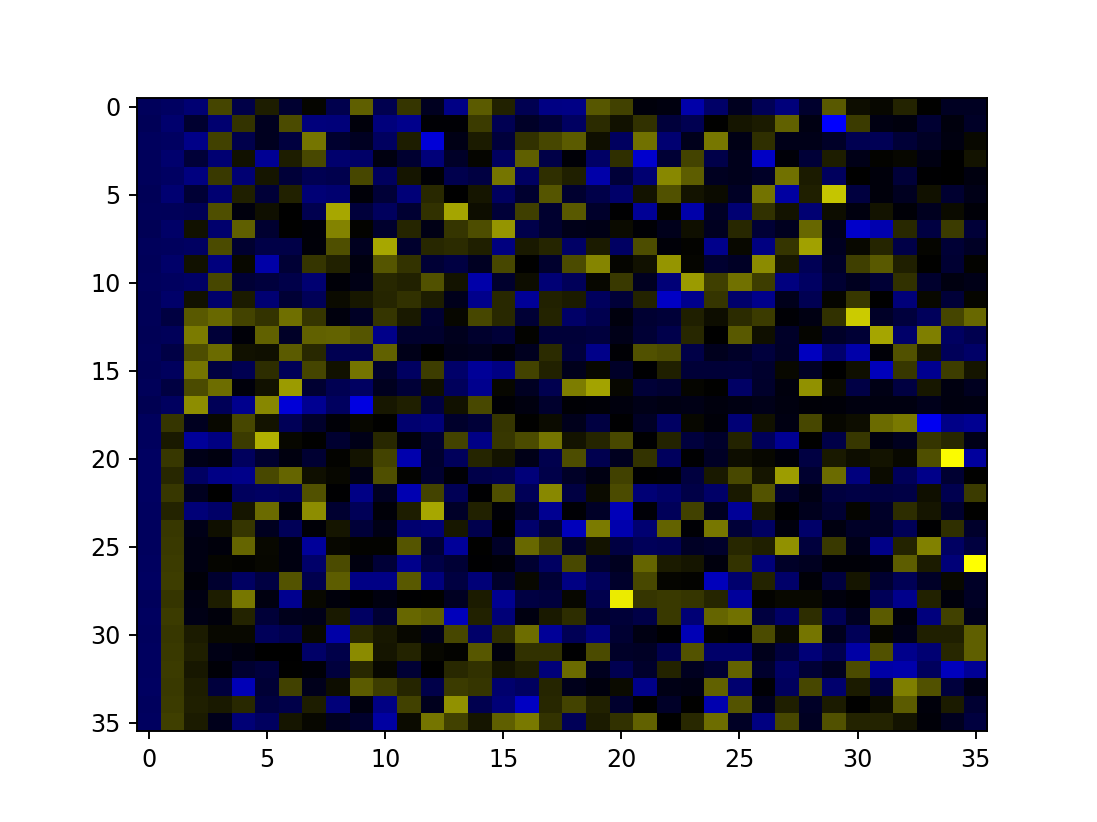

In [21]:
fig = plt.figure()
plt.imshow(u, interpolation="none", aspect="auto",cmap=cmap_yb)

<IPython.core.display.Javascript object>


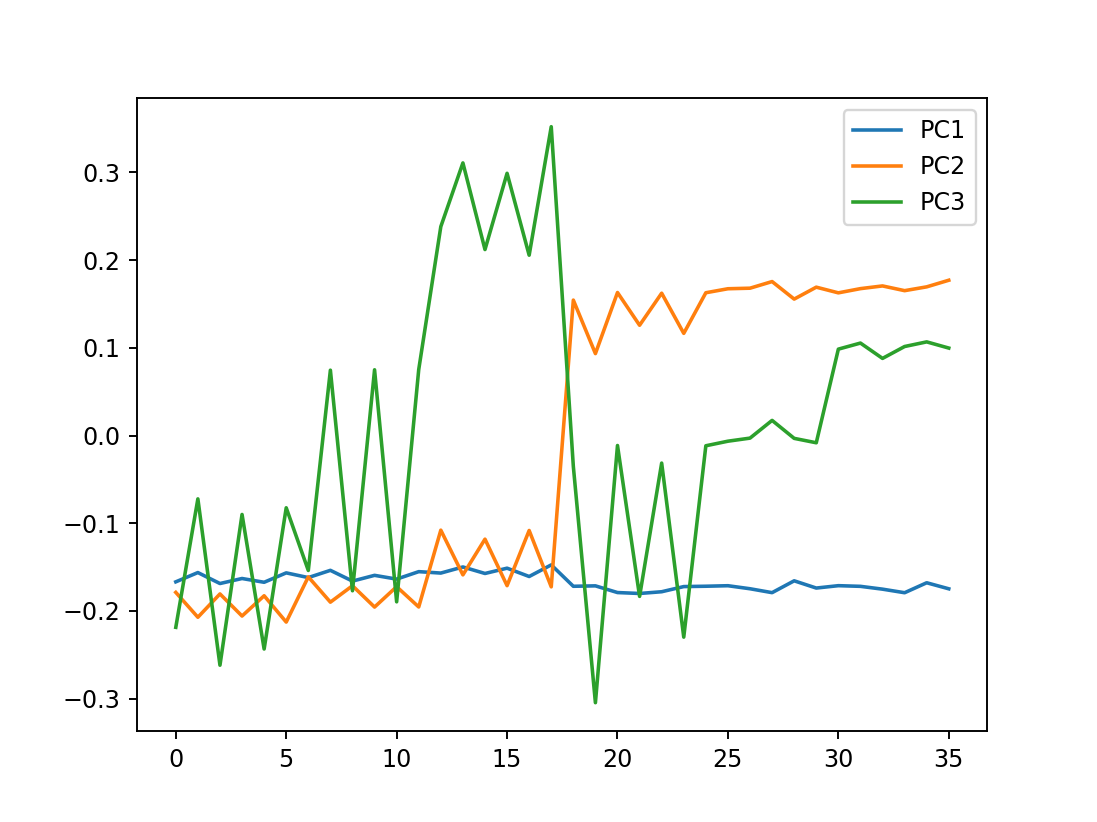

In [22]:
fig = plt.figure()
plt.plot(u[:,0],label="PC1")
plt.plot(u[:,1],label="PC2")
plt.plot(u[:,2],label="PC3")
plt.legend()

In [23]:
P = np.dot(A,u)
P.shape

(9939, 36)

In [24]:
P.shape

(9939, 36)

<IPython.core.display.Javascript object>


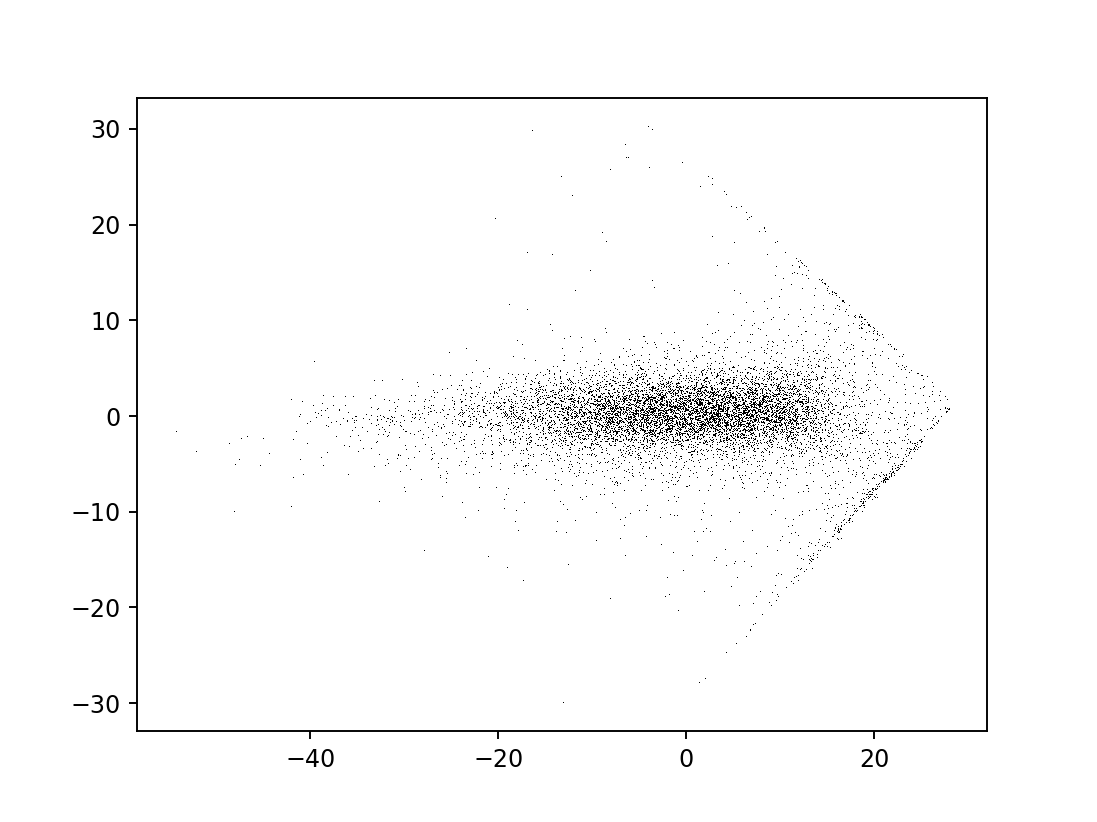

In [25]:
fig = plt.figure()
plt.plot(P[:,0],P[:,1],"k,")

In [26]:
A = col_center(col_center(D.T).T)
u,s,v = np.linalg.svd(A.T, full_matrices = False)
u.shape

(36, 36)

<IPython.core.display.Javascript object>


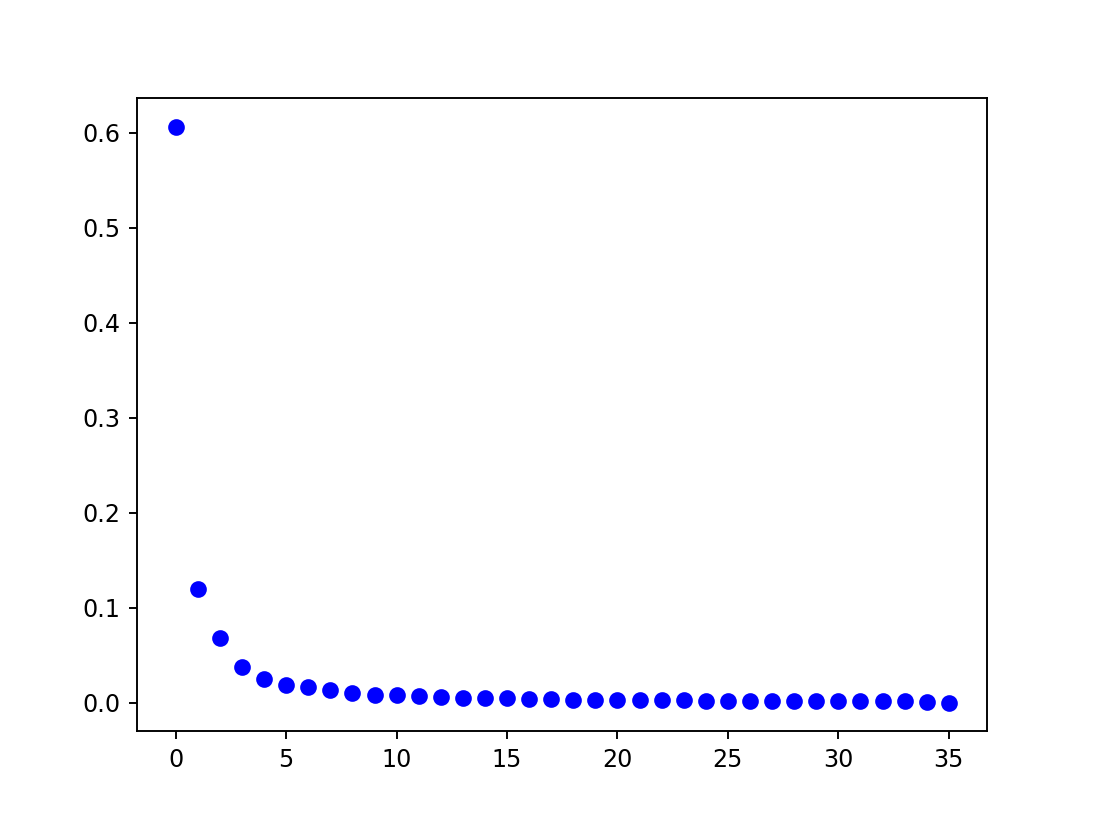

In [27]:
v = s**2
fig = plt.figure()
plt.plot(v/sum(v),"bo")

<IPython.core.display.Javascript object>


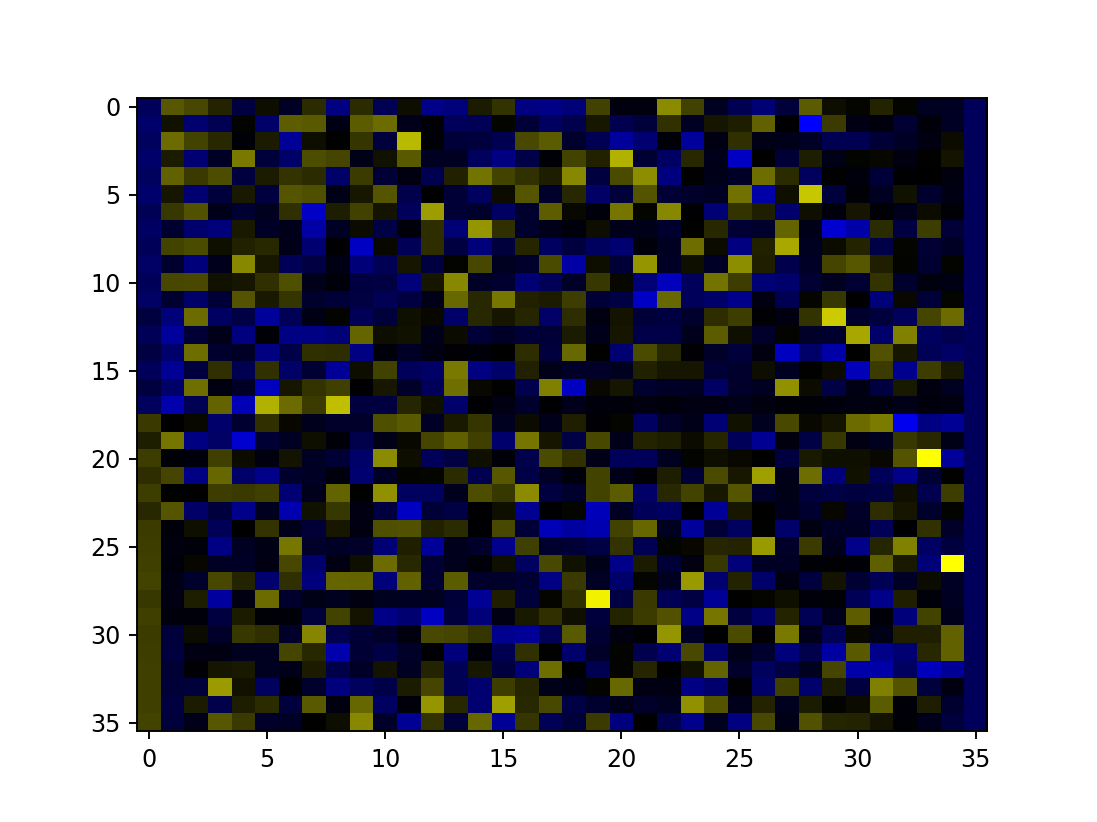

In [28]:
fig = plt.figure()
plt.imshow(u, interpolation="none", aspect="auto",cmap=cmap_yb)

<IPython.core.display.Javascript object>


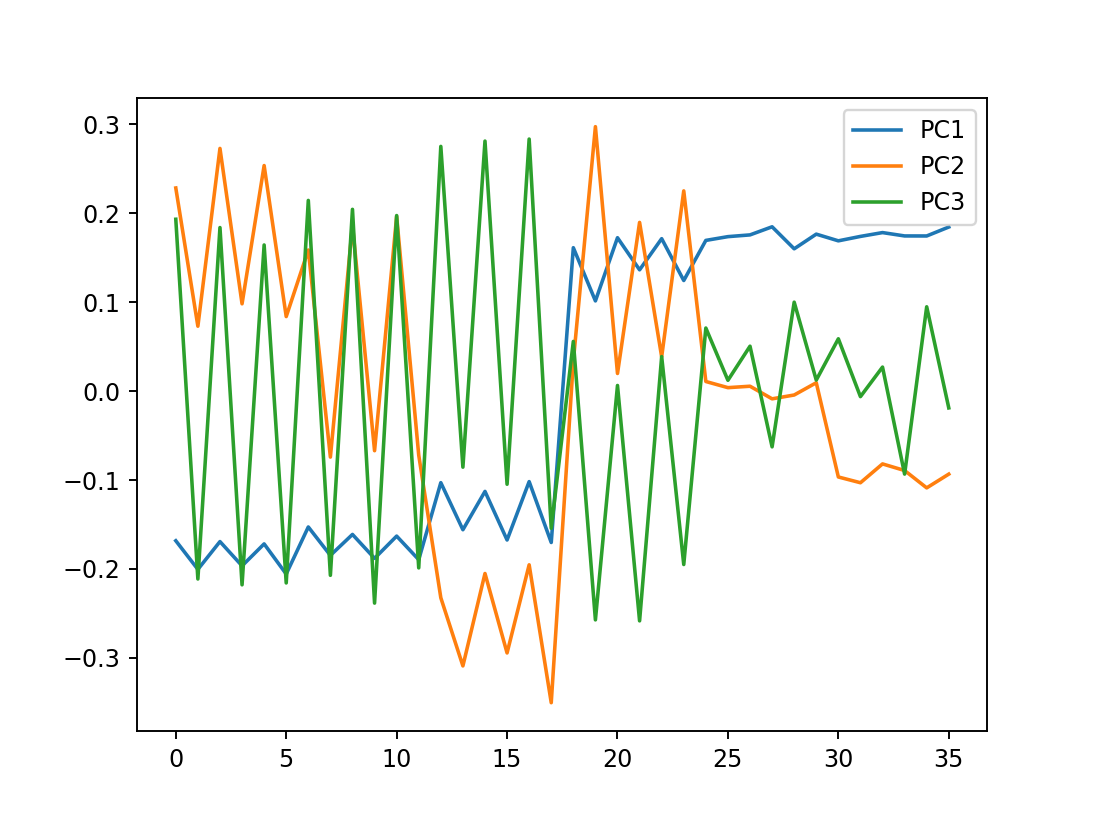

In [29]:
fig = plt.figure()
plt.plot(u[:,0],label="PC1")
plt.plot(u[:,1],label="PC2")
plt.plot(u[:,2],label="PC3")
plt.legend()

In [30]:
P = np.dot(A,u)
P.shape

(9939, 36)

<IPython.core.display.Javascript object>


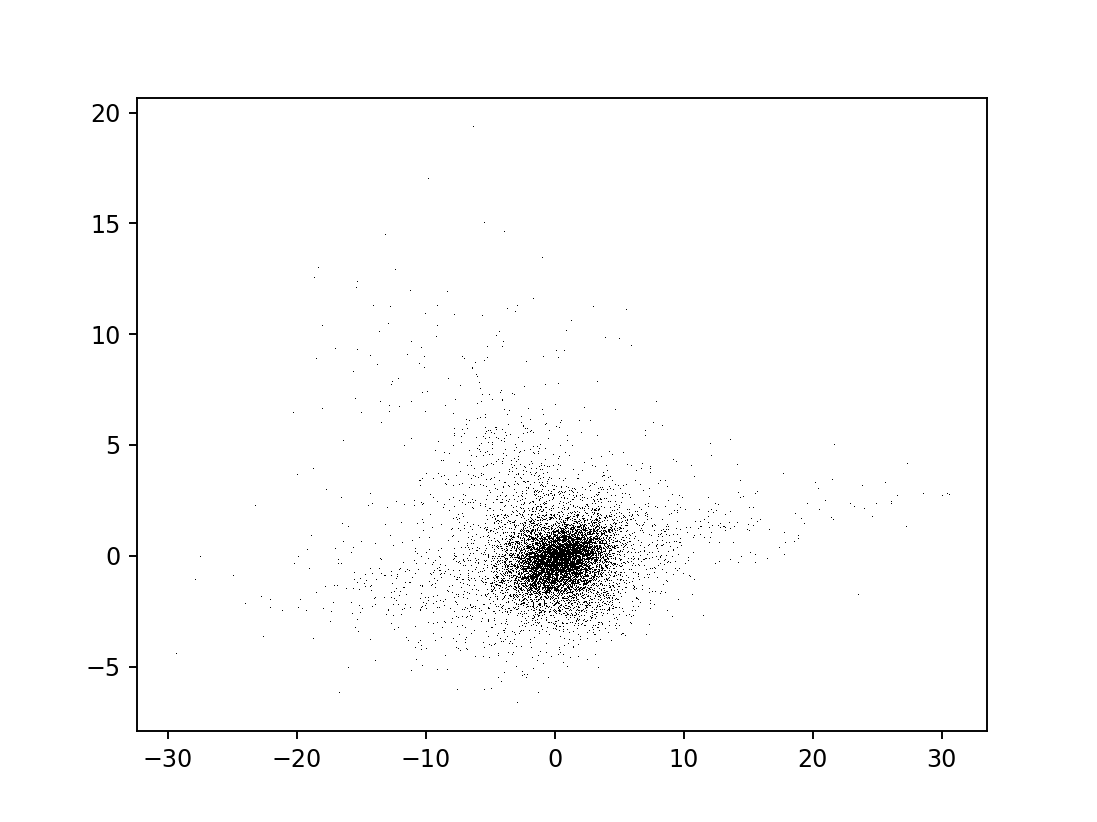

In [31]:
fig = plt.figure()
plt.plot(P[:,0],P[:,1],"k,")

In [32]:
cut2x = np.max(A,axis=1) >= 1

In [33]:
Acut2x = A[cut2x]
Acut2x.shape

(4872, 36)

In [34]:
Pcut2x = P[cut2x]

<IPython.core.display.Javascript object>


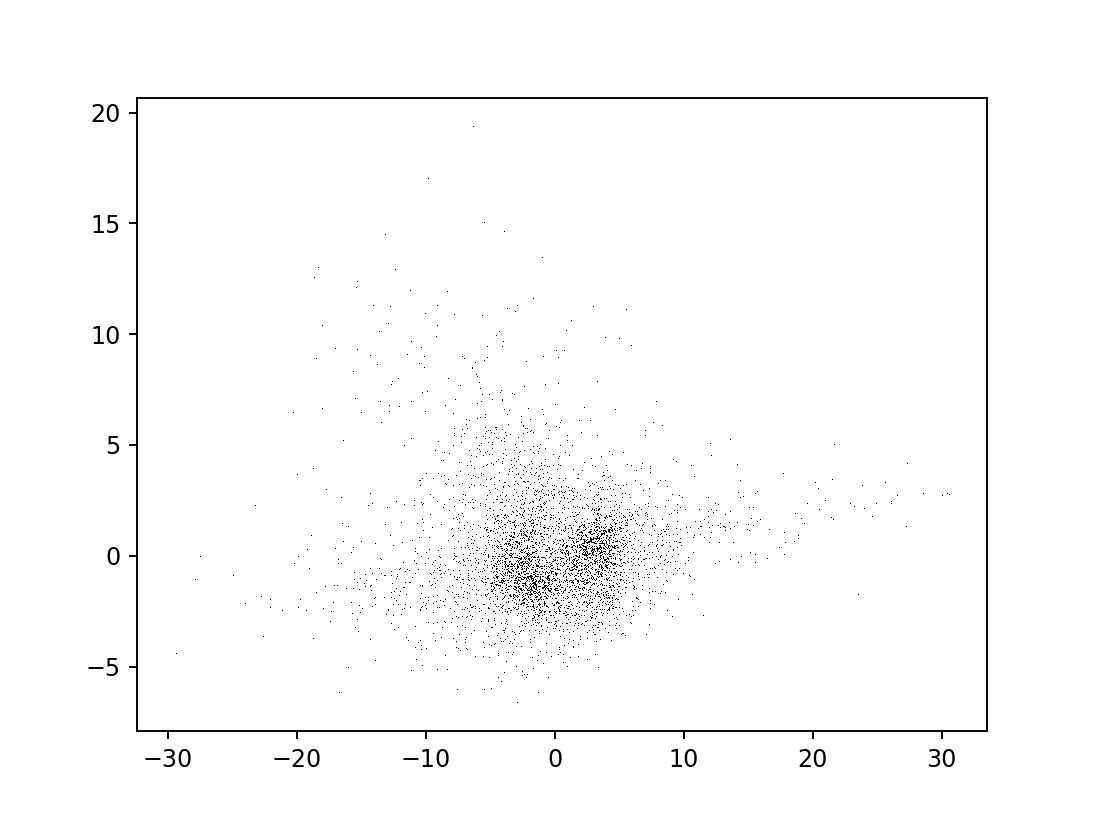

In [35]:
fig = plt.figure()
plt.plot(Pcut2x[:,0],Pcut2x[:,1],"k,")

In [36]:
import Bio.Cluster as Pycluster

In [37]:
%%time
tree = Pycluster.treecluster(Acut2x, dist="u", method="m")

CPU times: user 21.2 s, sys: 168 ms, total: 21.3 s
Wall time: 21.8 s


In [38]:
Acut2x.shape,Pcut2x.shape,np.hstack((Acut2x,Pcut2x)).shape

((4872, 36), (4872, 36), (4872, 72))

In [39]:
record = Pycluster.Record()
record.data = np.hstack((Acut2x,Pcut2x))
record.geneid = orfs[:]
record.genename = names[:]
record.gweight = None
record.gorder = None
record.expid = header[:]+["PC%02d" % i for i in range(len(header))]
record.eweight = None
record.eorder = None
record.uniqid = "UNIQID"
record.save("PCA_clustering_example1.um", geneclusters = tree)

In [40]:
fp = open("PCA_clustering_example1.um.cdt")
header = next(fp).split("\t")
header[:10]

['GID',
 'UNIQID',
 'NAME',
 'GWEIGHT',
 'BMDM_Live_1_4h',
 'BMDM_Live_1_24h',
 'BMDM_Live_2_4h',
 'BMDM_Live_2_24h',
 'BMDM_Live_3_4h',
 'BMDM_Live_3_24h']

In [41]:
out = open("PCA_clustering_example1.um.annotated.cdt","w")
out.write("\t".join(header[:3]+["rank"]+header[3:]))

839

In [42]:
eweights = next(fp).split("\t")
eweights[:10]

['EWEIGHT',
 '',
 '',
 '',
 '1.000000',
 '1.000000',
 '1.000000',
 '1.000000',
 '1.000000',
 '1.000000']

In [43]:
out.write("\t".join(header[:3]+[""]+header[3:]))

835

In [44]:
for (n,line) in enumerate(fp):
    row = line.split("\t")
    out.write("\t".join(row[:3]+[str(n)]+row[3:]))

In [45]:
out.close()